
## Goal

- Component in Tensorflow
  - RNN: LSTM / GRU
  - Attention Mechanism
  - GAN

- Next: 
  - Pointer-Generator Networks
  - Reinforcement Learning


## Recap
- data
    - [784] -> [10]

- model [LR/SVM/etc]
  - train
  - predict

- evaluation


## Recap (Cont.)

- Model

```python
# define the placeholder

# define the variables

# build the model graph
# including: predict, loss, and train_op
```

- Homework: Text Classification Task
  - [model](https://github.com/rgtjf/tf-classification/blob/master/src/models/NBoW.py)
  - [data](https://github.com/rgtjf/tf-classification/blob/master/src/data.py)
  - [main](https://github.com/rgtjf/tf-classification/blob/master/src/main.py)

- EASY to change to LSTM, HOW?
  - [model](https://github.com/rgtjf/tf-classification/blob/master/src/models/LSTM.py)

In [ ]:
 def BiLSTM(input_x, input_x_len, hidden_size, num_layers=1, dropout_rate=None, return_sequence=True):
    """
    BiLSTM Layer
    Args:
      input_x: [batch, sent_len, emb_size]
      input_x_len: [batch, ]
      hidden_size: int
      num_layers: int
      dropout_rate: float
      return_sequence: True/False
    Returns:
      if return_sequence=True:
          outputs: [batch, sent_len, hidden_size*2]
      else:
          output: [batch, hidden_size*2]
    """
    # cell = tf.contrib.rnn.GRUCell(hidden_size)
    cell_fw = tf.contrib.rnn.BasicLSTMCell(hidden_size)
    cell_bw = tf.contrib.rnn.BasicLSTMCell(hidden_size)

    if num_layers > 1:
        # Warning! Please consider that whether the cell to stack are the same
        cell_fw = tf.contrib.rnn.MultiRNNCell([cell_fw for _ in range(num_layers)])
        cell_bw = tf.contrib.rnn.MultiRNNCell([cell_bw for _ in range(num_layers)])

    if dropout_rate:
        cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, output_keep_prob=(1 - dropout_rate))
        cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, output_keep_prob=(1 - dropout_rate))

    b_outputs, b_states = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, input_x,
                                                            sequence_length=input_x_len, dtype=tf.float32)
    if return_sequence:
        outputs = tf.concat(b_outputs, axis=2)
    else:
        # states: [c, h]
        outputs = tf.concat([b_states[0][1], b_outputs[1][1]], axis=-1)
    return outputs

with tf.variable_scope("bilstm") as s:
    lstm_x = BiLSTM(embedded_x, self.input_x_len, self.lstm_size, return_sequence=True)

### RNNCell
$h_t = \sigma(W^{(hh)}h_{t-1}+W^{(hx)}x_t) + b$

In [ ]:
class BasicRNNCell(RNNCell):
    """The most basic RNN cell."""
    def __init__(self, num_units, input_size=None, activation=tanh):
        if input_size is not None:
            logging.warn("%s: The input_size parameter is deprecated.", self)
        self._num_units = num_units
        self._activation = activation

    @property
    def state_size(self):
        return self._num_units

    @property
    def output_size(self):
        return self._num_units

    def __call__(self, inputs, state, scope=None):
        """Most basic RNN: output = new_state = act(W * input + U * state + B)."""
        with vs.variable_scope(scope or "basic_rnn_cell"):
            output = self._activation(
              _linear([inputs, state], self._num_units, True, scope=scope))
        return output, output

### GRUCell
$r_t = \sigma(W^{(r)}x_t + U^{(r)}h_{t-1} + b^{(r)})$

$u_t = \sigma(W^{(u)}x_t + U^{(u)}h_{t-1} + b^{(u)})$

$c = \tanh\big( W^{(c)}x_t   + U^{(c)}(r_t \odot h_{t-1})  + b^{(c)}\big)$

$h_t = u_t \odot h_{t-1} + (1-u_t) \odot c$

In [ ]:
class GRUCell(RNNCell):
    """Gated Recurrent Unit cell (cf. http://arxiv.org/abs/1406.1078)."""
    def __init__(self, num_units, input_size=None, activation=tanh):
        if input_size is not None:
            logging.warn("%s: The input_size parameter is deprecated.", self)
        self._num_units = num_units
        self._activation = activation

    @property
    def state_size(self):
        return self._num_units

    @property
    def output_size(self):
        return self._num_units

    def __call__(self, inputs, state, scope=None):
        """Gated recurrent unit (GRU) with nunits cells."""
        with vs.variable_scope(scope or "gru_cell"):
            with vs.variable_scope("gates"):  # Reset gate and update gate.
            # We start with bias of 1.0 to not reset and not update.
            r, u = array_ops.split(
                value=_linear(
                    [inputs, state], 2 * self._num_units, True, 1.0, scope=scope),
                num_or_size_splits=2,
                axis=1)
            r, u = sigmoid(r), sigmoid(u)
            with vs.variable_scope("candidate"):
            c = self._activation(_linear([inputs, r * state], self._num_units, True, scope=scope))
            new_h = u * state + (1 - u) * c
        return new_h, new_h

### LSTMCell

$i_t = \sigma(W^{(i)}x_t + U^{(i)}h_{t-1} + b^{(i)})$

$f_t = \sigma(W^{(f)}x_t + U^{(f)}h_{t-1} + b^{(f)})$

$o_t = \sigma(W^{(o)}x_t + U^{(o)}h_{t-1} + b^{(o)})$

$\tilde{c_t} = \tanh(W^{(c)}x_t + U^{(c)}h_{t-1} + b^{(c)}))$

$c_t = i_t \odot \tilde{c_t} + f_t \odot c_{t-1}$

$h_t = o_t \odot \tanh(c_t)$


In [ ]:
class BasicLSTMCell(RNNCell):
    """Basic LSTM recurrent network cell.
    The implementation is based on: http://arxiv.org/abs/1409.2329.
    We add forget_bias (default: 1) to the biases of the forget gate in order to
    reduce the scale of forgetting in the beginning of the training.
    It does not allow cell clipping, a projection layer, and does not
    use peep-hole connections: it is the basic baseline.
    For advanced models, please use the full LSTMCell that follows.
    """
    def __init__(self, num_units, forget_bias=1.0, input_size=None,
               state_is_tuple=True, activation=tanh):
    """Initialize the basic LSTM cell.
    Args:
      num_units: int, The number of units in the LSTM cell.
      forget_bias: float, The bias added to forget gates (see above).
      input_size: Deprecated and unused.
      state_is_tuple: If True, accepted and returned states are 2-tuples of
        the `c_state` and `m_state`.  If False, they are concatenated
        along the column axis.  The latter behavior will soon be deprecated.
      activation: Activation function of the inner states.
    """
        if not state_is_tuple:
            logging.warn("%s: Using a concatenated state is slower and will soon be "
                       "deprecated.  Use state_is_tuple=True.", self)
        if input_size is not None:
            logging.warn("%s: The input_size parameter is deprecated.", self)
        self._num_units = num_units
        self._forget_bias = forget_bias
        self._state_is_tuple = state_is_tuple
        self._activation = activation

    @property
    def state_size(self):
        return (LSTMStateTuple(self._num_units, self._num_units) if self._state_is_tuple else 2 * self._num_units)

    @property
    def output_size(self):
        return self._num_units

    def __call__(self, inputs, state, scope=None):
        """Long short-term memory cell (LSTM)."""
        with vs.variable_scope(scope or "basic_lstm_cell"):
            # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = array_ops.split(value=state, num_or_size_splits=2, axis=1)
            concat = _linear([inputs, h], 4 * self._num_units, True, scope=scope)

            # i = input_gate, j = new_input, f = forget_gate, o = output_gate
            i, j, f, o = array_ops.split(value=concat, num_or_size_splits=4, axis=1)

            new_c = (c * sigmoid(f + self._forget_bias) + sigmoid(i) * self._activation(j))
            new_h = self._activation(new_c) * sigmoid(o)

            if self._state_is_tuple:
                new_state = LSTMStateTuple(new_c, new_h)
            else:
                new_state = array_ops.concat([new_c, new_h], 1)
            return new_h, new_state

## Attention Mechanism

$\alpha_i = softmax_i q^T W p_i$

$o  = \sum_i \alpha_i p_i$

In [ ]:
def bilinear_attention(question_rep, passage_repres, passage_mask):
    """
    Attention bilinear
    ref: https://arxiv.org/pdf/1606.02858v2.pdf
         https://github.com/danqi/rc-cnn-dailymail/blob/master/code/nn_layers.py
    $\alpha_i = softmax_i q^T W p_i$
    $ o  = \sum_i \alpha_i p_i $

      Args:
        question_rep: [batch_size, hidden_size]
        passage_repres: [batch_size, sequence_length, hidden_size]
        passage_mask: [batch_size, sequence_length]
      Returns:
        passage_rep: [batch_size, hidden_size]
    """
    hidden_size = question_rep.get_shape()[1]
    # [hidden_size, hidden_size]
    W_bilinear = tf.get_variable("W_bilinear", shape=[hidden_size, hidden_size], dtype=tf.float32)

    # [batch_size, hidden_size]
    question_rep = tf.matmul(question_rep, W_bilinear)
    
    # [batch_size, 1, hidden_size]
    question_rep = tf.expand_dims(question_rep, 1)
    
    # [batch_size, seq_length]
    alpha = tf.nn.softmax(tf.reduce_sum(question_rep * passage_repres, axis=2))
    alpha = alpha * passage_mask
    alpha = alpha / tf.reduce_sum(alpha, axis=-1, keep_dims=True)

    # [batch_size, hidden_size]
    passage_rep = tf.reduce_sum(passage_repres * tf.expand_dims(alpha, axis=-1), axis=1)
    return passage_rep

## GAN

### GAN Overview

<img src="http://www.timzhangyuxuan.com/static/images/project_DCGAN/structure.png" alt="nn" style="width: 800px;"/>

References:
- [Generative adversarial nets](https://arxiv.org/pdf/1406.2661.pdf). I Goodfellow, J Pouget-Abadie, M Mirza, B Xu, D Warde-Farley, S Ozair, Y. Bengio. Advances in neural information processing systems, 2672-2680.
- [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a.html). X Glorot, Y Bengio. Aistats 9, 249-256

Other tutorials:
- [Generative Adversarial Networks Explained](http://kvfrans.com/generative-adversial-networks-explained/). Kevin Frans.

### MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/


In [4]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf

In [5]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data", one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
# Training Params
num_steps = 70000
batch_size = 128
learning_rate = 0.0002

# Network Params
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 # Noise data points

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [7]:
# Store layers weight & bias
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
}
biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
}

In [8]:
# Generator
def generator(x):
    hidden_layer = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Discriminator
def discriminator(x):
    hidden_layer = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

# Build Generator Network
gen_sample = generator(gen_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample)

# Build Loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            biases['gen_hidden1'], biases['gen_out']]
# Discriminator Network Variables
disc_vars = [weights['disc_hidden1'], weights['disc_out'],
            biases['disc_hidden1'], biases['disc_out']]

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

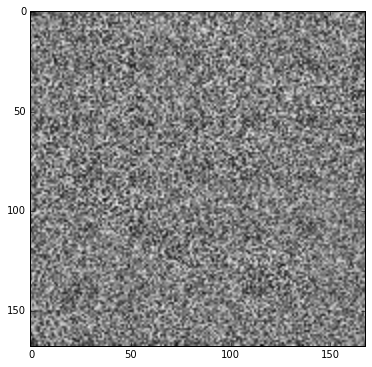

In [12]:
sess = tf.Session()

# Run the initializer
sess.run(init)

# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    g = sess.run(gen_sample, feed_dict={gen_input: z})
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

In [13]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                            feed_dict=feed_dict)
    if i % 2000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 0.923284, Discriminator Loss: 1.042895
Step 2000: Generator Loss: 4.833409, Discriminator Loss: 0.021220
Step 4000: Generator Loss: 6.696794, Discriminator Loss: 0.002756
Step 6000: Generator Loss: 4.635538, Discriminator Loss: 0.057187
Step 8000: Generator Loss: 4.217852, Discriminator Loss: 0.140082
Step 10000: Generator Loss: 4.189685, Discriminator Loss: 0.124197
Step 12000: Generator Loss: 3.410398, Discriminator Loss: 0.311642
Step 14000: Generator Loss: 3.622142, Discriminator Loss: 0.228207
Step 16000: Generator Loss: 3.543054, Discriminator Loss: 0.276637
Step 18000: Generator Loss: 3.719631, Discriminator Loss: 0.182660
Step 20000: Generator Loss: 3.623107, Discriminator Loss: 0.213775
Step 22000: Generator Loss: 2.944718, Discriminator Loss: 0.392091
Step 24000: Generator Loss: 3.156914, Discriminator Loss: 0.333854
Step 26000: Generator Loss: 3.389464, Discriminator Loss: 0.369781
Step 28000: Generator Loss: 3.506766, Discriminator Loss: 0.367945
Ste

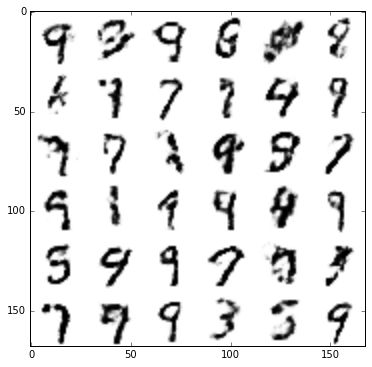

In [14]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    g = sess.run(gen_sample, feed_dict={gen_input: z})
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

## More
- [DCGAN](https://arxiv.org/pdf/1511.06434.pdf)
- [DCGAN, ipynb](http://precision:8888/notebooks/ipynb/dcgan.ipynb)

- [text-to-image](https://github.com/zsdonghao/text-to-image)

![DCGAN](https://github.com/rgtjf/ecnunlp-tensorflow-tutorial/raw/master/lecture2/figs/dcgan.jpg)